## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = keras.layers.BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = keras.layers.BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [11]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = [16, 32, 128, 256]

In [12]:
results = {}

for bb in BATCH_SIZE:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with %s Drop" % (bb))
        model = build_mlp(input_shape=x_train.shape[1:])
        model.summary()
        optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=bb, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "exp-%s" % (str(bb))
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}


Experiment with 16 Drop
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)            

Epoch 19/20
50000/50000 [==============================] - 77s 2ms/step - loss: 1.1013 - acc: 0.6104 - val_loss: 1.3819 - val_acc: 0.5179
Epoch 20/20
50000/50000 [==============================] - 80s 2ms/step - loss: 1.0868 - acc: 0.6145 - val_loss: 1.4192 - val_acc: 0.5036
Experiment with 128 Drop
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256

50000/50000 [==============================] - 18s 351us/step - loss: 0.8501 - acc: 0.6976 - val_loss: 1.5859 - val_acc: 0.4810
Epoch 17/20
50000/50000 [==============================] - 17s 343us/step - loss: 0.8153 - acc: 0.7125 - val_loss: 1.7268 - val_acc: 0.4614
Epoch 18/20
50000/50000 [==============================] - 17s 349us/step - loss: 0.7915 - acc: 0.7193 - val_loss: 1.6407 - val_acc: 0.4817
Epoch 19/20
50000/50000 [==============================] - 17s 344us/step - loss: 0.7587 - acc: 0.7296 - val_loss: 2.7708 - val_acc: 0.3083
Epoch 20/20
50000/50000 [==============================] - 18s 354us/step - loss: 0.7278 - acc: 0.7432 - val_loss: 1.8403 - val_acc: 0.4451


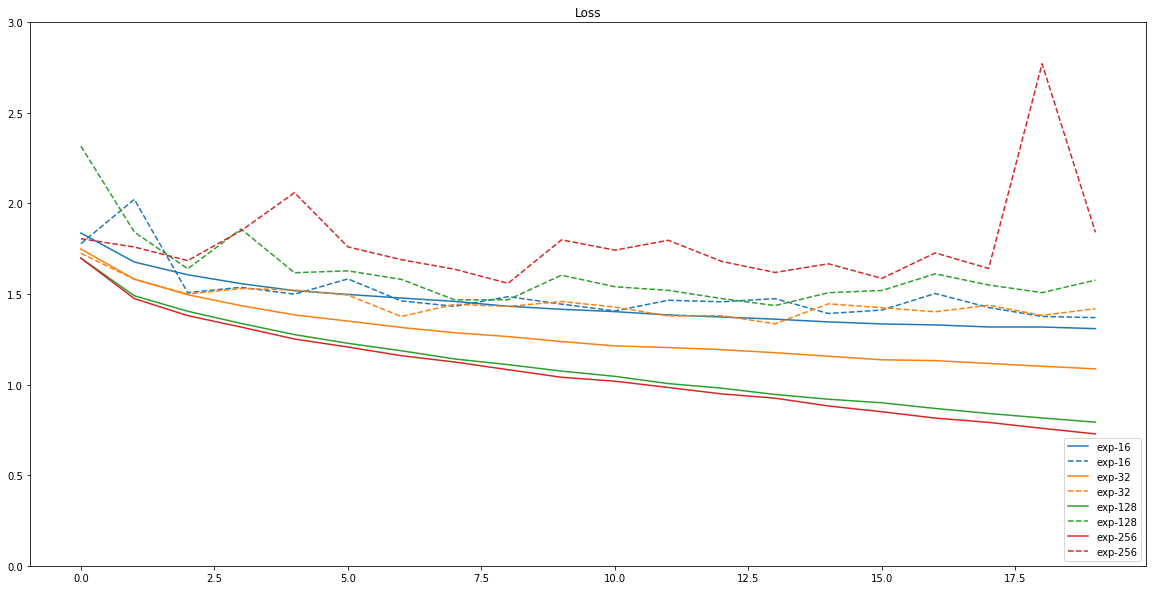

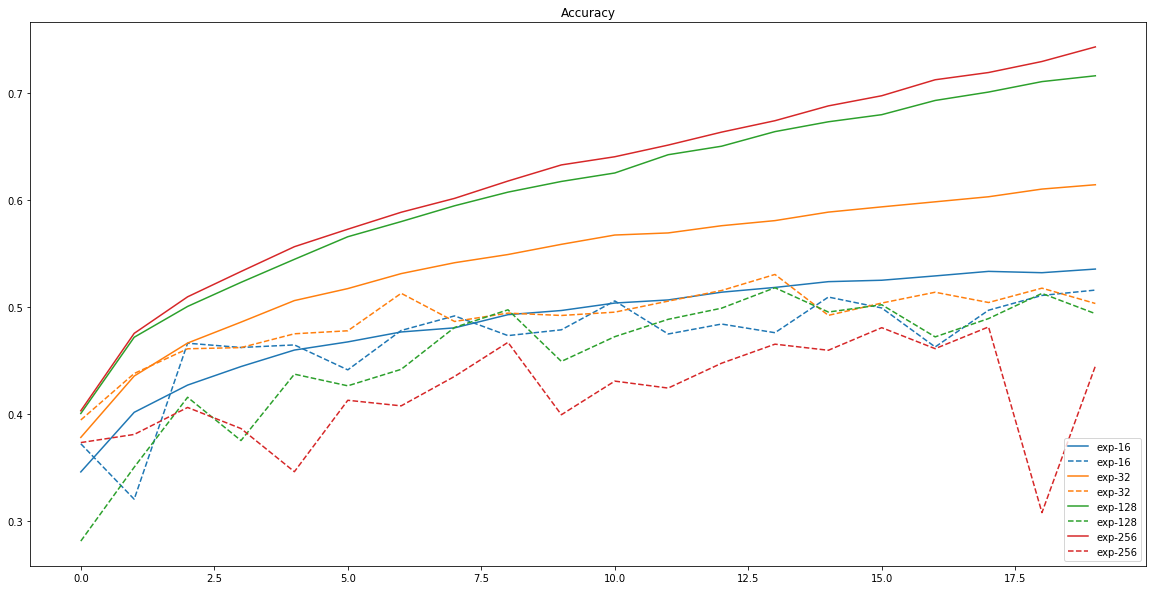

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', "r", "g", "b"]
plt.figure(figsize=(20,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 3])
plt.legend(loc=4)
plt.show()

plt.figure(figsize=(20,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc=4)
plt.show()

In [15]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,  
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation("relu")(x)
        else:
            x = keras.layers.Dense(units=n_units,  
                                   name="hidden_layer"+str(i+1))(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.Activation("relu")(x)
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [16]:
results = {}

keras.backend.clear_session() # 把舊的 Graph 清掉
print("Experiment with %s Drop" % (bb))
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
                  epochs=20, 
                  batch_size=128, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

exp_name_tag = "exp-%s" % (str(bb))
results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}


Experiment with 256 Drop
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 (Activation)    (None, 256)           

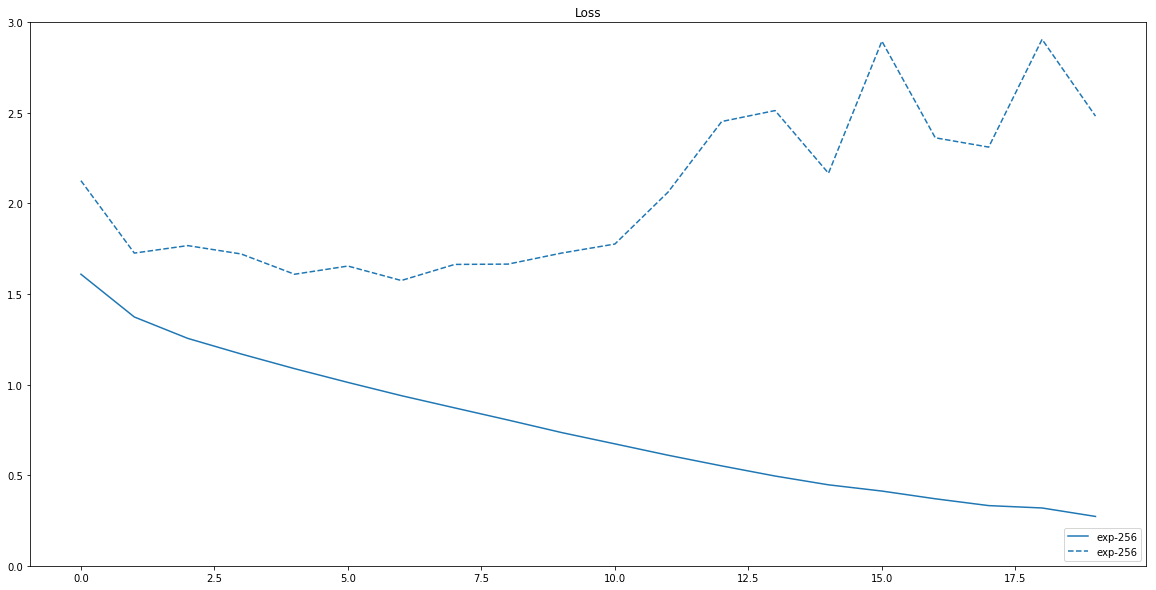

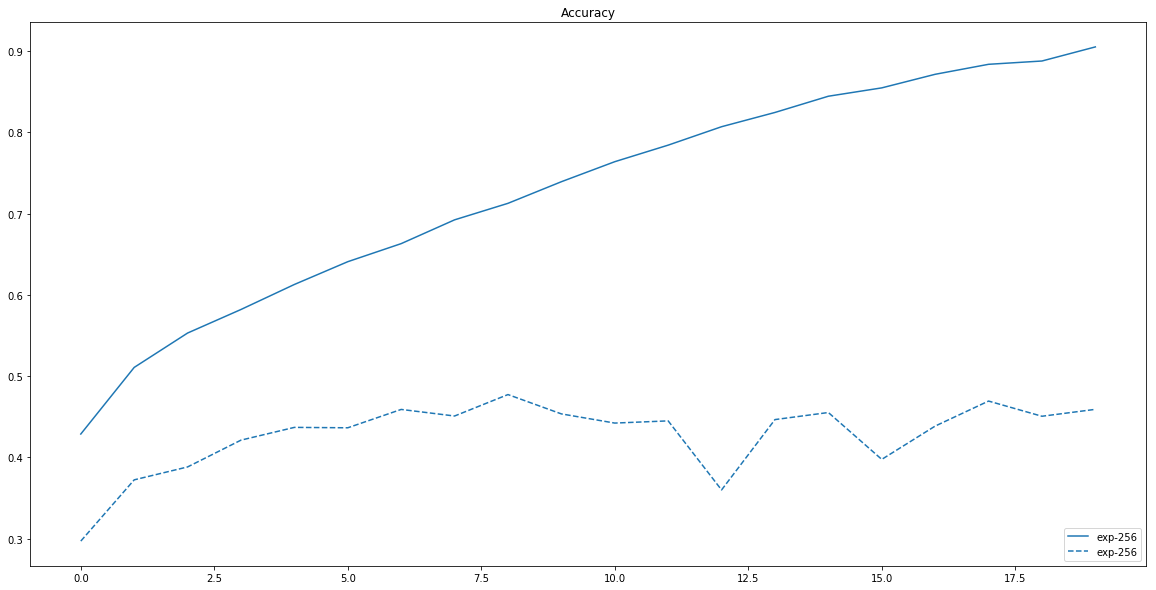

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', "r", "g", "b"]
plt.figure(figsize=(20,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 3])
plt.legend(loc=4)
plt.show()

plt.figure(figsize=(20,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc=4)
plt.show()

In [20]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = keras.layers.BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = keras.layers.BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [21]:
results = {}

keras.backend.clear_session() # 把舊的 Graph 清掉
print("Experiment with %s Drop" % (bb))
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
                  epochs=20, 
                  batch_size=128, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

exp_name_tag = "exp-%s" % (str(bb))
results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}


Experiment with 256 Drop
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)           

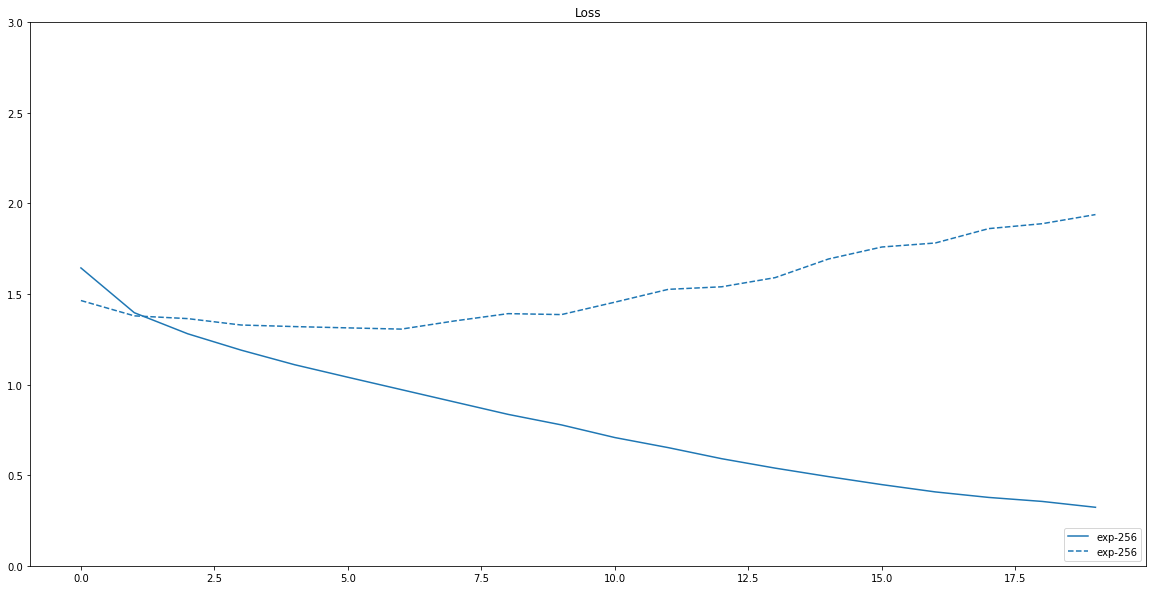

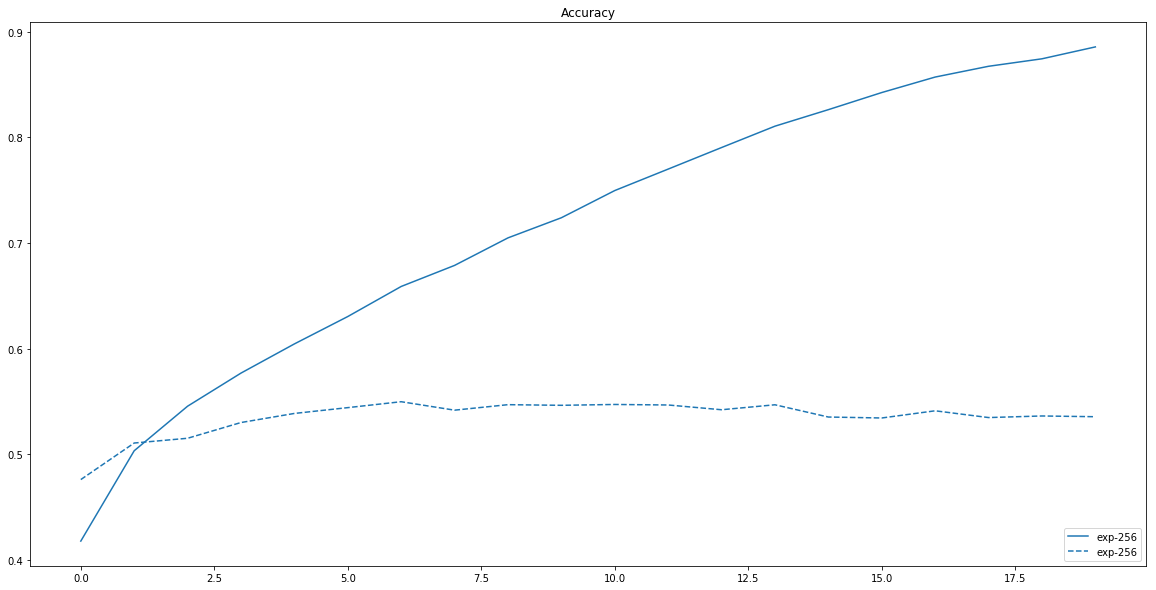

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', "r", "g", "b"]
plt.figure(figsize=(20,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 3])
plt.legend(loc=4)
plt.show()

plt.figure(figsize=(20,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc=4)
plt.show()